In this notebook, we will introduce PyTorch framework and building a simple model using PyTorch. We will also look at how to back propagate in PyTorch.

In [1]:
pip install torchviz -q

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn
import numpy as np
from sklearn.metrics import mean_squared_error

from torch.utils import data as T
import torch
from torchviz import make_dot, make_dot_from_trace
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import time
import matplotlib.patches as mpatches
import plotly.io as pio
pio.renderers.default = 'notebook'

/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Dataset description
We are using 20 years of Gamestop (GME) stock market data from Yahoo! Finance. Data is from June 15, 2003 to June 14, 2023.

In [4]:
gme = pd.read_csv('https://ist691.s3.us-east-2.amazonaws.com/GME.csv')
gme

,Date,Open,High,Low,Close,Adj Close,Volume
0,2/14/02,2.543750,2.548750,2.481250,2.500000,1.683250,11021600
1,2/15/02,2.500000,2.506250,2.462500,2.487500,1.674834,8389600
2,2/19/02,2.475000,2.475000,2.343750,2.387500,1.607504,7410400
3,2/20/02,2.400000,2.468750,2.381250,2.468750,1.662209,6892800
4,2/21/02,2.460000,2.481250,2.437500,2.462500,1.658002,6976800
...,...,...,...,...,...,...,...
5365,6/8/23,20.299999,22.000000,20.100000,21.440001,21.440001,19213300
5366,6/9/23,21.780001,23.430000,21.500000,22.680000,22.680000,10321200
5367,6/12/23,22.850000,24.299999,22.740000,24.299999,24.299999,7131400
5368,6/13/23,26.200001,27.650000,25.030001,26.950001,26.950001,17160600


#### We are only using the closing price of the stock on a particular day as our variable of interest.

In [5]:
gme = np.array(gme['Close'])

#### Train, validation, and test data

We create 3 different data sets for training, validation and testing. We will use the last two years of data for testing, the 3rd to last year for validation, and remaining data for training.

In [6]:
# each array needs to be reshaped from 1-d to 2-d for MinMaxScaler() in the next step
train_data = gme[:4613].reshape(-1, 1)
validation_data = gme[4613:4866].reshape(-1, 1)
test_data = gme[4866:].reshape(-1, 1)

In [7]:
# initializing scaler object
scaler = MinMaxScaler()

# fitting our training data into scaler object
scaler = scaler.fit(train_data)

# transforming training, testing and validation data using scaler object
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
validation_data = scaler.transform(validation_data)

The following function creates a sequence based on the sequence length provided as the parameters. It will create a new dataset with feature as the number of days of data as the sequence and the target variable as the following day's closing price. Suppose sequence is 3, then the first 3 data elements will be our X or features and the 4th day data will be our Y or the target variable.

In [8]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
seq_length = 4

# creating sequential data for training, testing and validation set
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_val, y_val = create_sequences(validation_data, seq_length)

# converting our features and target for all three set into tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

Here is the first training sequence.

In [10]:
X_train[0]

tensor([[0.1190],
        [0.1182],
        [0.1116],
        [0.1169]])

And here is the target for the sequence above.

In [11]:
y_train[0]

tensor([0.1165])

Remember that our original data has been transformed using `MinMaxScaler`.

In [12]:
gme[0:5]

array([2.5    , 2.4875 , 2.3875 , 2.46875, 2.4625 ])

For the first task, which is plain backpropogation, we create a model with 1 hidden layer and a sigmoid activation function. Since we have created sequences of 4 features, we will have 4 input nodes and our output will be 1 node.

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return x

In [13]:
summary(Model(), input_size = (4022,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 4022, 16]              80
            Linear-2             [-1, 4022, 32]             544
            Linear-3              [-1, 4022, 1]              33
Total params: 657
Trainable params: 657
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 1.50
Params size (MB): 0.00
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


We have to reshape the data for our linear model. Since we will pass one dimensional data, and our data is
in 2 dimensions. So we will use reshape function to re-shape the data.
Example: `[[[1],[2],[3]]] -> shape is (1,3,1)`

The above data is in 3 dimensions, where the first dimension indicates total number of rows in our data, and the second and third
dimensions give us the dimension of the data passed into the model.

So we have to convert `(1,3,1) => (1,3)` so that we can pass that into our linear model.

In [14]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: torch.Size([4608, 4, 1])
X_val shape: torch.Size([248, 4, 1])
X_test shape: torch.Size([499, 4, 1])


In [15]:
train = X_train.reshape(4608,4)
validation = X_val.reshape(248,4)
test = X_test.reshape(499,4)

In [16]:
model = Model()
# make_dot(model(X_train), params=dict(model.named_parameters()))

In [17]:
num_epochs = 300

learning_rate = 0.01

X_train = train[0]
y_train = train[1]

X_val = validation[0]
y_val = validation[1]

# loss functiom
criterion = torch.nn.MSELoss() # mean-squared error for regression

# initialization of Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# initilizing empty list for storing training loss, test loss and computation time
train_lss = []
val_loss = []

# train the model
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, y_train)
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_lss = criterion(y_val_pred.float(), y_val)
        val_loss.append(val_lss.item())
    train_lss.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print("Epoch: %d, training loss: %1.5f , validation loss: %1.5f"
              % (epoch, loss.item(),val_lss.item()))



/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 0, training loss: 0.00001 , validation loss: 0.00708
Epoch: 20, training loss: 0.00119 , validation loss: 0.00238
Epoch: 40, training loss: 0.00067 , validation loss: 0.01181
Epoch: 60, training loss: 0.00001 , validation loss: 0.00720
Epoch: 80, training loss: 0.00001 , validation loss: 0.00685
Epoch: 100, training loss: 0.00001 , validation loss: 0.00699
Epoch: 120, training loss: 0.00001 , validation loss: 0.00696
Epoch: 140, training loss: 0.00001 , validation loss: 0.00687
Epoch: 160, training loss: 0.00001 , validation loss: 0.00689
Epoch: 180, training loss: 0.00001 , validation loss: 0.00689
Epoch: 200, training loss: 0.00001 , validation loss: 0.00689
Epoch: 220, training loss: 0.00001 , validation loss: 0.00689
Epoch: 240, training loss: 0.00001 , validation loss: 0.00689
Epoch: 260, training loss: 0.00001 , validation loss: 0.00689
Epoch: 280, training loss: 0.00001 , validation loss: 0.00689


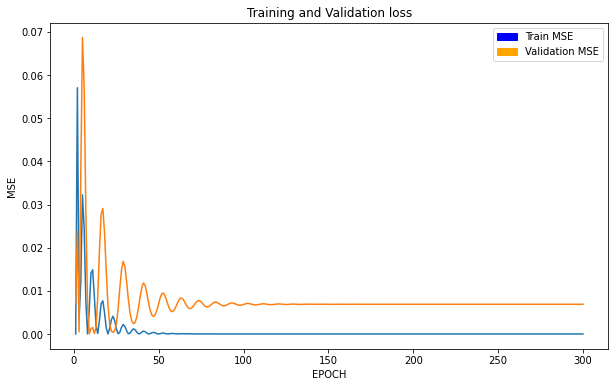

In [18]:
blue_patch = mpatches.Patch(color = 'blue', label = 'Train MSE')
green_patch = mpatches.Patch(color = 'orange', label = 'Validation MSE')

plt.figure(figsize=(10,6))

sns.lineplot(x=range(1,300+1),y = train_lss)
sns.lineplot(x=range(1,300+1),y = val_loss)

plt.xlabel('EPOCH')
plt.ylabel('MSE')
plt.legend(handles = [blue_patch,green_patch])
plt.title('Training and Validation loss');
